In [ ]:
!pip uninstall tensorflow

!pip install tensorflow==2.2.0

Uninstalling tensorflow-2.3.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.3.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 516.2MB 30kB/s 
     |████████████████████████████████| 3.0MB 59.2MB/s 
     |████████████████████████████████| 460kB 53.8MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0


In [ ]:
!pip install tqdm
!pip install tqdm --upgrade

     |████████████████████████████████| 71kB 2.0MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
!nvidia-smi

Mon Aug 24 11:15:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Librerías

In [3]:
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import os
import datetime
from google.colab import files

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Embedding,Reshape, Concatenate
from tensorflow.keras import Model
from keras.utils import plot_model
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from keras import metrics
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.optimizers import Adam,SGD
from tqdm.keras import TqdmCallback

# Load the TensorBoard notebook extension
%load_ext tensorboard
# 1st line tensorboard stuff (don't write comments in the same line as a magic)

from keras.callbacks import TensorBoard  # 2nd line tensorboard stuff
import itertools

from numpy.random import seed
seed(11)
tf.random.set_seed(11)

%matplotlib inline

In [ ]:
print(tf.__version__)

2.2.0


## Importamos los datos

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
cols = ['CODE','DURATION','COLOR','YEAR','DIRECTOR','RATING','COUNTRY_0','GENRES_0','GENRES_1','GENRES_2','LANGUAGE_0','KEYWORDS_0','KEYWORDS_1','KEYWORDS_2','WRITERS_0','CONTENT_RATING','KEYWORDS_DESCRIPTION','ACTOR_0','ACTOR_1','ACTOR_2']
data = pd.read_csv('/content/drive/My Drive/TFM/data/imdb_data.csv',header=0,decimal=',',usecols=cols)

data['KEYWORDS_1'] = data['KEYWORDS_1'].astype(str)
data['KEYWORDS_2'] = data['KEYWORDS_2'].astype(str)
data['WRITERS_0'] = data['WRITERS_0'].astype(str)
data['CODE'] = data['CODE'].apply(lambda x: x.replace('tt',''))

In [49]:
data['RATING']  = data['RATING'].astype(float)
data['RATING_CAT'] = pd.cut(data['RATING'], bins = [0,5, 6.5,10], labels=['1','2','3'])
data.head()

,CODE,DURATION,COLOR,YEAR,DIRECTOR,RATING,CONTENT_RATING,GENRES_0,GENRES_1,GENRES_2,LANGUAGE_0,KEYWORDS_0,KEYWORDS_1,KEYWORDS_2,COUNTRY_0,WRITERS_0,KEYWORDS_DESCRIPTION,ACTOR_0,ACTOR_1,ACTOR_2,RATING_CAT
0,4686108,106,Color,2017,JohnDoe,5.3,1,Drama,Musical,Drama,English,poetry,college,rap,USA,JaneDoe,azealia,PepitoDoe,PepitaDoe,JosefinaDoe,2
1,0445033,162,Color,2004,LawrenceRaghavendra,6.4,1,Action,Drama,Action,Telugu,mafia,friend,revenge,India,JaneDoe,friend,NagarjunaAkkineni,NagarjunaAkkineni,Raghuvaran,2
2,1167599,85,Color,2009,MichaelHerbig,5.5,1,Action,Adventure,Comedy,German,hidinginabox,hidinginachest,vikingship,Germany,MichaelHerbig,viking,PepitoDoe,PepitaDoe,JosefinaDoe,2
3,4823434,83,Color,2017,IssaLÃƒÂ³pez,7.0,1,Fantasy,Horror,Mystery,Spanish,mexicanhorror,producedbydirector,titledirectedbyfemale,Mexico,IssaLÃƒÂ³pez,war,PepitoDoe,PepitaDoe,JosefinaDoe,3
4,0220100,97,Color,2000,MikeFiggis,6.0,1,Drama,Romance,Drama,English,audition,jealousy,realtime,USA,MikeFiggis,hollywood,JeanneTripplehorn,JeanneTripplehorn,SalmaHayek,2


In [50]:
print(len(data[data['RATING_CAT']=='3']),len(data[data['RATING_CAT']=='3'])/len(data), '%')
print(len(data[data['RATING_CAT']=='2']),len(data[data['RATING_CAT']=='2'])/len(data),'%')
print(len(data[data['RATING_CAT']=='1']),len(data[data['RATING_CAT']=='1'])/len(data),'%')

22331 0.37452410901467503 %
26164 0.43880922431865826 %
11130 0.18666666666666668 %


## Seleccionamos features y hacemos el split

In [32]:
features = [0,1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
target = [20]
X = data.iloc[:,features]
y = data.iloc[:,target]

In [33]:
ency = OneHotEncoder(handle_unknown='ignore', sparse = False)
ency.fit(y.values)
y_one_hot = ency.transform(y.values)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, stratify = y_one_hot,random_state=22)

In [35]:
X_train.head()

,CODE,DURATION,COLOR,YEAR,DIRECTOR,CONTENT_RATING,GENRES_0,GENRES_1,GENRES_2,LANGUAGE_0,KEYWORDS_0,KEYWORDS_1,KEYWORDS_2,COUNTRY_0,WRITERS_0,KEYWORDS_DESCRIPTION,ACTOR_0,ACTOR_1,ACTOR_2
35310,0468644,110,Color,2007,JoramLÃƒÂ¼rsen,1,Comedy,Romance,Comedy,Dutch,frated,prince,schoolteacher,Netherlands,JaneDoe,sinterklaas,PepitoDoe,PepitaDoe,JosefinaDoe
1572,0059915,93,Color,1965,HaraldReinl,2,Action,Adventure,Western,German,italowestern,spaghettiwestern,friend,WestGermany,KarlMay,winnetou,LexBarker,LexBarker,RikBattaglia
34073,0070689,89,Color,1972,JohnDoe,1,Drama,Mystery,Drama,English,playingfootsie,surrealism,buddhist,USA,JaneDoe,indian,ShashiKapoor,ShashiKapoor,JosefinaDoe
35658,0041084,79,BlackandWhite,1949,JosephM.Newman,1,Crime,Drama,Film-Noir,English,blackmarketbaby,potboiler,femalegangleader,USA,JaneDoe,newspaperman,DennisO'Keefe,DennisO'Keefe,JosefinaDoe
17440,0076770,56,Color,1977,JosephMcGrath,1,Comedy,Crime,Mystery,English,referencetodoctorjohnwatson,referencetoherculepoirot,professormoriartycharacter,UK,JaneDoe,moriarty,JohnCleese,JohnCleese,JosefinaDoe


## Preparamos los datos para introducirlos de manera correcta al embedding

In [51]:
categorical_vars = ['COLOR','DIRECTOR','GENRES_0','GENRES_1','GENRES_2','LANGUAGE_0','COUNTRY_0','KEYWORDS_0','KEYWORDS_1','KEYWORDS_2','WRITERS_0','CONTENT_RATING','KEYWORDS_DESCRIPTION','ACTOR_0','ACTOR_1','ACTOR_2']
numeric_vars = ['DURATION','YEAR']

In [52]:
def preproc(X_train, X_test, categorical_vars=categorical_vars, numeric_vars=numeric_vars):
    
    """Asigna ids a la variables categoricas
    Return: Devuelve una lista por cada caloumna del dataframe con sus registros correspondientes"""
    input_list_train = []
    input_list_test = []
    map_list = []

    for c in categorical_vars:

      raw_vals = np.unique(X_train[c])
      val_map = {}
      for i in range(len(raw_vals)):
          val_map[raw_vals[i]] = i       
      
      input_list_train.append(X_train[c].map(val_map).values)
  
      input_list_test.append(X_test[c].map(val_map).fillna(0).values)

      map_list.append(val_map)
      

    for n in numeric_vars:
    
      input_list_train.append(X_train[n].values)
      input_list_test.append(X_test[n].values)
    
    return input_list_train, input_list_test, map_list

In [53]:
input_list_train, input_list_test, map_list = preproc(X_train,X_test)

## Generamos arrays necesarios para la app

In [54]:
for num,cat_name in enumerate(categorical_vars):

  dictionary = map_list[num]
  np.save(cat_name+'.npy', dictionary) 


## Creamos dos métricas personalizadas


In [55]:
def recall_class(y_true, y_pred, class_id):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)

    recall_mask = K.cast(K.equal(class_id_true, class_id), 'int32')
    class_recall_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * recall_mask
    class_recall = K.sum(class_recall_tensor) / K.maximum(K.sum(recall_mask), 1)

    return class_recall

In [56]:
def precision_class(y_true, y_pred, class_id):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)

    precision_mask = K.cast(K.equal(class_id_preds, class_id), 'int32')
    class_prec_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * precision_mask
    class_prec = K.sum(class_prec_tensor) / K.maximum(K.sum(precision_mask), 1)

    return class_prec

In [57]:
def f1_class(y_true, y_pred,class_id):

    class_prec = precision_class(y_true, y_pred, class_id)
    class_recall = recall_class(y_true, y_pred, class_id)
    class_f1 = 2*((class_prec*class_recall)/(class_prec+class_recall+K.epsilon()))

    return class_f1

In [58]:
def precision_total(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = K.cast(true_positives / (predicted_positives + K.epsilon()), 'float64')
    return precision

In [59]:
def custom_metric(y_true, y_pred):
  
  recall_0 = recall_class(y_true, y_pred, 0)
  f1_1 = f1_class(y_true, y_pred,1)
  precision_2 = precision_class(y_true, y_pred, 2)
  total_precision = precision_total(y_true, y_pred)

  metric = (recall_0 + f1_1 + precision_2)/3
  return metric

In [60]:
def custom_metric2(y_true, y_pred):
  
  recall_0 = recall_class(y_true, y_pred, 0)
  f1_1 = f1_class(y_true, y_pred,1)
  precision_2 = precision_class(y_true, y_pred, 2)
  total_precision = precision_total(y_true, y_pred)

  metric = (recall_0 + f1_1 + precision_2 + total_precision)/4
  return metric

## Creamos el modelo

In [62]:
def create_mlp_embedding(categorical_vars,numeric_vars,numeric_neurons):

  input_models=[]
  output_embeddings=[]

  for categorical_var in categorical_vars:
      
      cat_emb_name= categorical_var +'_Embedding'
      input_name= 'Input_' + categorical_var
      no_of_unique_cat  = X_train[categorical_var].nunique()
      embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50))  #Formula empírica
      input_model = Input(shape=(1,), name=input_name)
      output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
      output_model = Reshape(target_shape=(embedding_size,))(output_model)    
      input_models.append(input_model)
      output_embeddings.append(output_model)

  for numeric_var in numeric_vars:

    if numeric_var != 'CODE':
  
      input_numeric = Input(shape=(1,),name=numeric_var+"_Input")
      dense_numeric = Dense(numeric_neurons)(input_numeric) 
      input_models.append(input_numeric)
      output_embeddings.append(dense_numeric)

  output = Concatenate()(output_embeddings)

  model = Model(inputs=input_models, outputs=output)
  return model,input_models

mlp_emb,input_mlp = create_mlp_embedding(categorical_vars,numeric_vars,numeric_neurons)

x = tf.keras.layers.BatchNormalization()(mlp_emb.output)
x = tf.keras.layers.Dropout(0.5)(x)
x = Dense(256,activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Dense(128,activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)

model = Model(inputs=mlp_emb.input, outputs=x)

### Variables

In [69]:
numeric_neurons = 16 #Neuronas de la dense asociada a las variables numéricas
learning_rate = 0.00001

adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
adagrad = tf.keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
rmsprop = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
adadelta = tf.keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
adamax = tf.keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
nadam = tf.keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

optimizer = adam

p1=6
p2=8

weights = {0:10, 1:p1, 2:p2}  # Pesos de la distribución del error según la clase

batch_size = 512

### Compilación

In [70]:
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy',custom_metric,custom_metric2])

### Entrenamiento

In [71]:
model_name = 'Tabular_app'

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=40)
mc = ModelCheckpoint('/content/drive/My Drive/ModelosApp/cm2'+model_name+'.h5', monitor='val_custom_metric2', mode='max', verbose=0, save_best_only=True,save_weights_only=False)
mc2 = ModelCheckpoint('/content/drive/My Drive/ModelosApp/cm1'+model_name+'.h5', monitor='val_custom_metric', mode='max', verbose=0, save_best_only=True,save_weights_only=False)
mc3 = ModelCheckpoint('/content/drive/My Drive/ModelosApp/vacc'+model_name+'.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True,save_weights_only=False)
mc4 = ModelCheckpoint('/content/drive/My Drive/ModelosApp/vloss'+model_name+'.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True,save_weights_only=False)

model.fit(input_list_train, y_train, batch_size=batch_size, epochs=10000, validation_data=(input_list_test, y_test), verbose=1,class_weight=weights,callbacks=[es, mc,mc2,mc3,mc4])

Epoch 1/10000
94/94 [==============================] - 8s 88ms/step - loss: 15.1115 - accuracy: 0.3349 - custom_metric: 0.3593 - custom_metric2: 0.3529 - val_loss: 19.0680 - val_accuracy: 0.1867 - val_custom_metric: 0.3333 - val_custom_metric2: 0.2967
Epoch 2/10000
94/94 [==============================] - 5s 55ms/step - loss: 14.5422 - accuracy: 0.3493 - custom_metric: 0.3801 - custom_metric2: 0.3727 - val_loss: 5.6075 - val_accuracy: 0.1867 - val_custom_metric: 0.3333 - val_custom_metric2: 0.2967
Epoch 3/10000
54/94 [================>.............] - ETA: 2s - loss: 14.0543 - accuracy: 0.3601 - custom_metric: 0.3925 - custom_metric2: 0.3849

KeyboardInterrupt: ignored

### Ejemplo de grid search

In [ ]:
neuronas1 = [256,512]
neuronas2 = [128,256]
droputs1 = [0.25,0.5]
droputs2 = [0.25,0.5]
for neurona1 in neuronas1:
  for neurona2 in neuronas2:
    for droput1 in droputs1:
      for droput2 in droputs2:


        mlp_emb,input_mlp = create_mlp_embedding(categorical_vars,numeric_vars,numeric_neurons)

        x = tf.keras.layers.BatchNormalization()(mlp_emb.output)
        x = tf.keras.layers.Dropout(droput1)(x)
        x = Dense(neurona1,activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(droput2)(x)
        x = Dense(neurona2,activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = Dense(3, activation='softmax')(x)

        model = Model(inputs=mlp_emb.input, outputs=x)
        model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy',custom_metric,custom_metric2])

        p1=6
        p2=8

        weights = {0:10, 1:p1, 2:p2}
        model_name = 'v-'+str(min_votes)+'lr-'+str(learning_rate)+'p1-'+str(p1)+'p2-'+str(p2)+'n1-'+str(neurona1)+'n2-'+str(neurona2)+'d1-'+str(droput1)+'d2-'+str(droput2)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=40)
        mc = ModelCheckpoint('cm2'+model_name+'.h5', monitor='val_custom_metric2', mode='max', verbose=0, save_best_only=True,save_weights_only=True)
        mc2 = ModelCheckpoint('cm1'+model_name+'.h5', monitor='val_custom_metric', mode='max', verbose=0, save_best_only=True,save_weights_only=True)
        mc3 = ModelCheckpoint('vacc'+model_name+'.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True,save_weights_only=True)
        mc4 = ModelCheckpoint('vloss'+model_name+'.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True,save_weights_only=True)

        model.fit(input_list_train, y_train, batch_size=512, epochs=10000, validation_data=(input_list_test, y_test), verbose=1,class_weight=weights,callbacks=[es, mc,mc2,mc3,mc4])

        #files.download(model_name+'.h5') 

Epoch 1/10000


KeyboardInterrupt: ignored

https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/

### Metricas de los modelos obtenidos


In [ ]:
model.load_weights('vaccv-125lr-1e-05p1-6p2-8.h5')

In [ ]:
loss, acc, score,score2 = model.evaluate(input_list_test, y_test,
                            batch_size=512)

24/24 [==============================] - 0s 6ms/step - loss: 0.7887 - accuracy: 0.6336 - custom_metric: 0.6662 - custom_metric2: 0.6648


In [ ]:
print('val_loss:',loss,'- val_accuracy:',acc,'- val_custom_metric:',score,'- val_custom_metric2:',score2)

val_loss: 0.7886560559272766 - val_accuracy: 0.6336268186569214 - val_custom_metric: 0.6661820411682129 - val_custom_metric2: 0.6647745966911316


In [ ]:
y_pred= model.predict([input_list_test])

matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [ ]:
matrix

array([[1456,  676,   94],
       [ 960, 3322,  951],
       [ 136, 1552, 2778]])

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
target_names = ['0-5', '5-6.5', '6.5-10']

Confusion matrix, without normalization
[[1456  676   94]
 [ 960 3322  951]
 [ 136 1552 2778]]


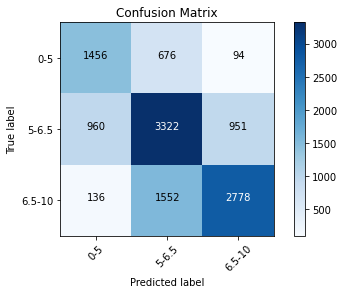

In [ ]:
plot_confusion_matrix(cm=matrix, classes=target_names, title='Confusion Matrix')

In [ ]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         0-5       0.57      0.65      0.61      2226
       5-6.5       0.60      0.63      0.62      5233
      6.5-10       0.73      0.62      0.67      4466

    accuracy                           0.63     11925
   macro avg       0.63      0.64      0.63     11925
weighted avg       0.64      0.63      0.64     11925



### Guardado del modelo en formato accesible para la app

In [ ]:
model.save('Modelo_tabular_App.h5')

In [ ]:
model = load_model('Modelo_tabular_App.h5',custom_objects={'custom_metric':custom_metric,'custom_metric2':custom_metric2},compile=False)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy'])

In [ ]:
model.save('/content/drive/My Drive/TFM/Codigos/Modelos_Arquitecturas_clasificación/Tabular_Modelo')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/TFM/Codigos/Modelos_Arquitecturas_clasificación/Tabular_Modelo/assets


### Figuras

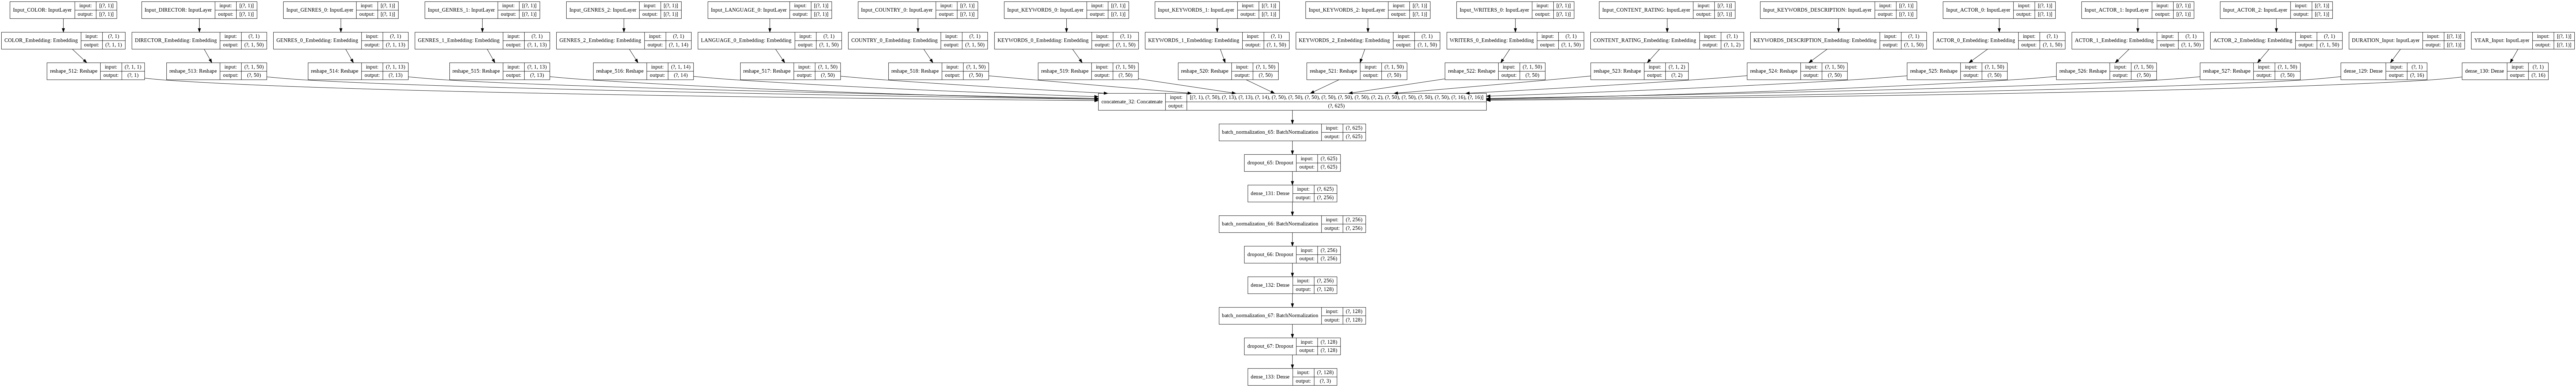

In [ ]:
plot_model(model, to_file='model3.png',show_shapes=True,show_layer_names=True)
Image(retina=True, filename='model3.png')

In [ ]:
model.summary()

Model: "functional_131"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_COLOR (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_DIRECTOR (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_GENRES_0 (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_GENRES_1 (InputLayer)     [(None, 1)]          0                                            
_____________________________________________________________________________________